In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
from tqdm import tqdm
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D, Activation, MaxPooling2D, Dropout, Flatten, Dense, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

Using TensorFlow backend.


In [2]:
input_size = 100
# image_size is (height, width)
image_size = (90, 160)
# image_size = (45, 80)
# image_size = (64, 64)
# image_size = (16, 16)

opt = Adam(lr=1e-4)
dopt = Adam(lr=1e-3)

nch = 50
g_input = Input(shape=(input_size,))
g_V = Dense(nch*image_size[0]*image_size[1])(g_input)
g_V = BatchNormalization()(g_V)
g_V = Activation('relu')(g_V)

# g_V = Dense(input_size*image_size[0]*image_size[1])(g_V)
# g_V = BatchNormalization()(g_V)
# g_V = Activation('relu')(g_V)
g_V = Reshape((*image_size, nch))(g_V)
# g_V = UpSampling2D(size=(2,2))(g_V)
g_V = Conv2D(filters=int(input_size/2), kernel_size=(3,3), padding="same", kernel_initializer="glorot_uniform")(g_V)
g_V = BatchNormalization()(g_V)
g_V = Activation('relu')(g_V)
g_V = Conv2D(filters=int(input_size/4), kernel_size=(3,3), padding="same", kernel_initializer="glorot_uniform")(g_V)
g_V = BatchNormalization()(g_V)
g_V = Activation('relu')(g_V)
g_V = Conv2D(filters=3, kernel_size=(1,1), padding="same", kernel_initializer="glorot_uniform")(g_V)
g_V = Activation('sigmoid')(g_V)
generator = Model(inputs=g_input, outputs=g_V)
generator.compile(loss="binary_crossentropy", optimizer=opt)
generator.summary()

d_input = Input(shape=(*image_size, 3))
d_V = Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), padding="same", activation="relu")(d_input)
d_V = LeakyReLU(0.2)(d_V)
d_V = Dropout(0.25)(d_V)
d_V = Conv2D(filters=512, kernel_size=(5,5), strides=(2,2), padding="same", activation="relu")(d_V)
d_V = LeakyReLU(0.2)(d_V)
d_V = Dropout(0.25)(d_V)
d_V = Flatten()(d_V)
d_V = Dense(256)(d_V)
d_V = Dropout(0.25)(d_V)
d_V = LeakyReLU(0.2)(d_V)
d_V = Dropout(0.25)(d_V)
d_V = Dense(2, activation="softmax")(d_V)
discriminator = Model(inputs=d_input, outputs=d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 720000)            72720000  
_________________________________________________________________
batch_normalization_1 (Batch (None, 720000)            2880000   
_________________________________________________________________
activation_1 (Activation)    (None, 720000)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 90, 160, 50)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 160, 50)       22550     
_________________________________________________________________
batch_normalization_2 (Batch (None, 90, 160, 50)       200       
__________

In [3]:
gan_input = Input(shape=(100,))
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(inputs=gan_input, outputs=gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)

In [ ]:
# load if we can find an existing model and weights for this image size
from keras.models import load_model

res_str = "{}x{}".format(*image_size)
model_file = Path("GAN_{}.h5".format(res_str))
weights_file = Path("GAN_weights_{}.h5".format(res_str))
if model_file.exists():
    print("loading model from file")
    model = load_model(model_file)
    if weights_file.exists():
        print("loading weights from file")
        model.load_weights(weights_file)

loading model from file


In [4]:
datagen = ImageDataGenerator(
            rotation_range=5,
            width_shift_range=0.1,
            height_shift_range=0.1,
            rescale=1./255,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=False,
            fill_mode='nearest',
            data_format="channels_last")

noise_gen_preview = np.random.uniform(0,1,size=[24,input_size]) # only to be used to generate preview

In [ ]:
def set_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
        
# def pretrain():
#     set_trainable(discriminator, True)
#     discriminator.fit()

def train(epochs=5000, batch_size=2, save_preview_every=5):
    flow_gen = datagen.flow_from_directory("data/good", shuffle=True, target_size=image_size, batch_size=batch_size, class_mode=None)
    for e in tqdm(range(epochs)):
        # Make generative images
#         print("generating")
        noise_gen = np.random.uniform(0,1,size=[batch_size,input_size])
        generated_images = generator.predict(noise_gen)

        # Train discriminator on generated images
#         print("training discriminator")
        image_batch = next(flow_gen)
#         print("image_batch: {} - generated_images: {}".format(image_batch.shape, generated_images.shape))
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*batch_size,2])
        y[0:batch_size,1] = 1
        y[batch_size:,0] = 1
        
        if X.shape[0] < y.shape[0]:
            y = y[:X.shape[0]]
        elif X.shape[0] > y.shape[0]:
            X = X[:y.shape[0]]
        
        set_trainable(discriminator, True)
        d_loss = discriminator.train_on_batch(X,y)
        
#         print("training generator")
        noise_tr = np.random.uniform(0,1,size=[batch_size,input_size])
        y2 = np.zeros([batch_size,2])
        y2[:,1] = 1
        
        set_trainable(discriminator, False)
        g_loss = GAN.train_on_batch(noise_tr, y2)
        
        if e % save_preview_every == 0:
            predict_and_save(noise_gen_preview, e)
        
def predict_and_save(noise, epoch_count):
    generated_images = generator.predict(noise)
    for i in range(generated_images.shape[0]):
        img = array_to_img(generated_images[i,:,:,:])
        img.save("preview/preview{}.png".format(epoch_count))
    
        

In [ ]:
train(epochs=1000, batch_size=8, save_preview_every=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

Found 1111 images belonging to 1 classes.


  3%|▎         | 29/1000 [05:51<3:13:01, 11.93s/it]/home/carson/Documents/code/ml-testing/.env/lib/python3.5/site-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (154159500 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
 96%|█████████▋| 964/1000 [23:17:26<06:44, 11.25s/it]        

Example input images
Found 996 images belonging to 1 classes.


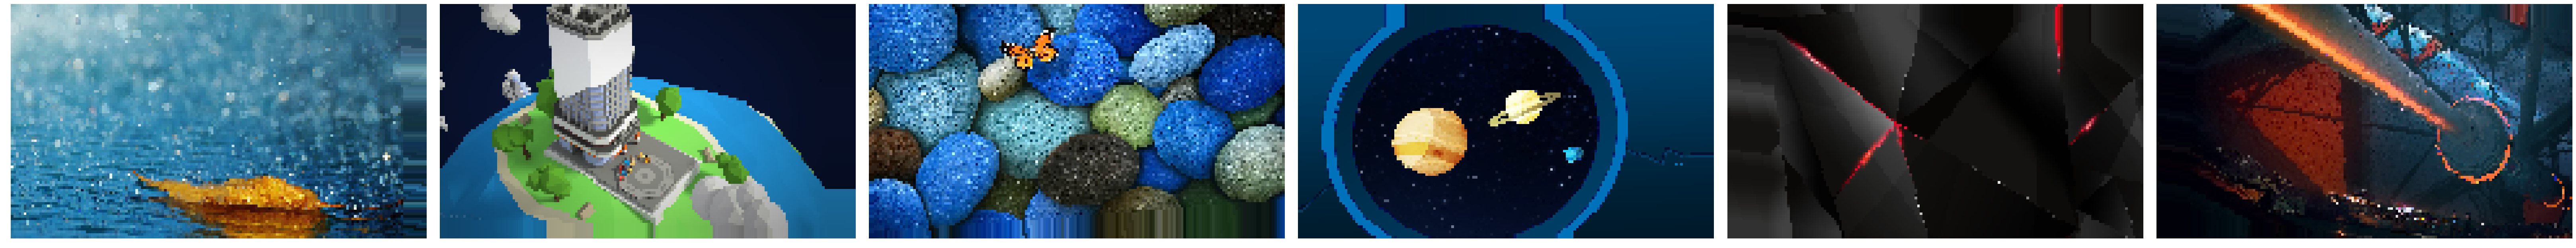

Generated outputs


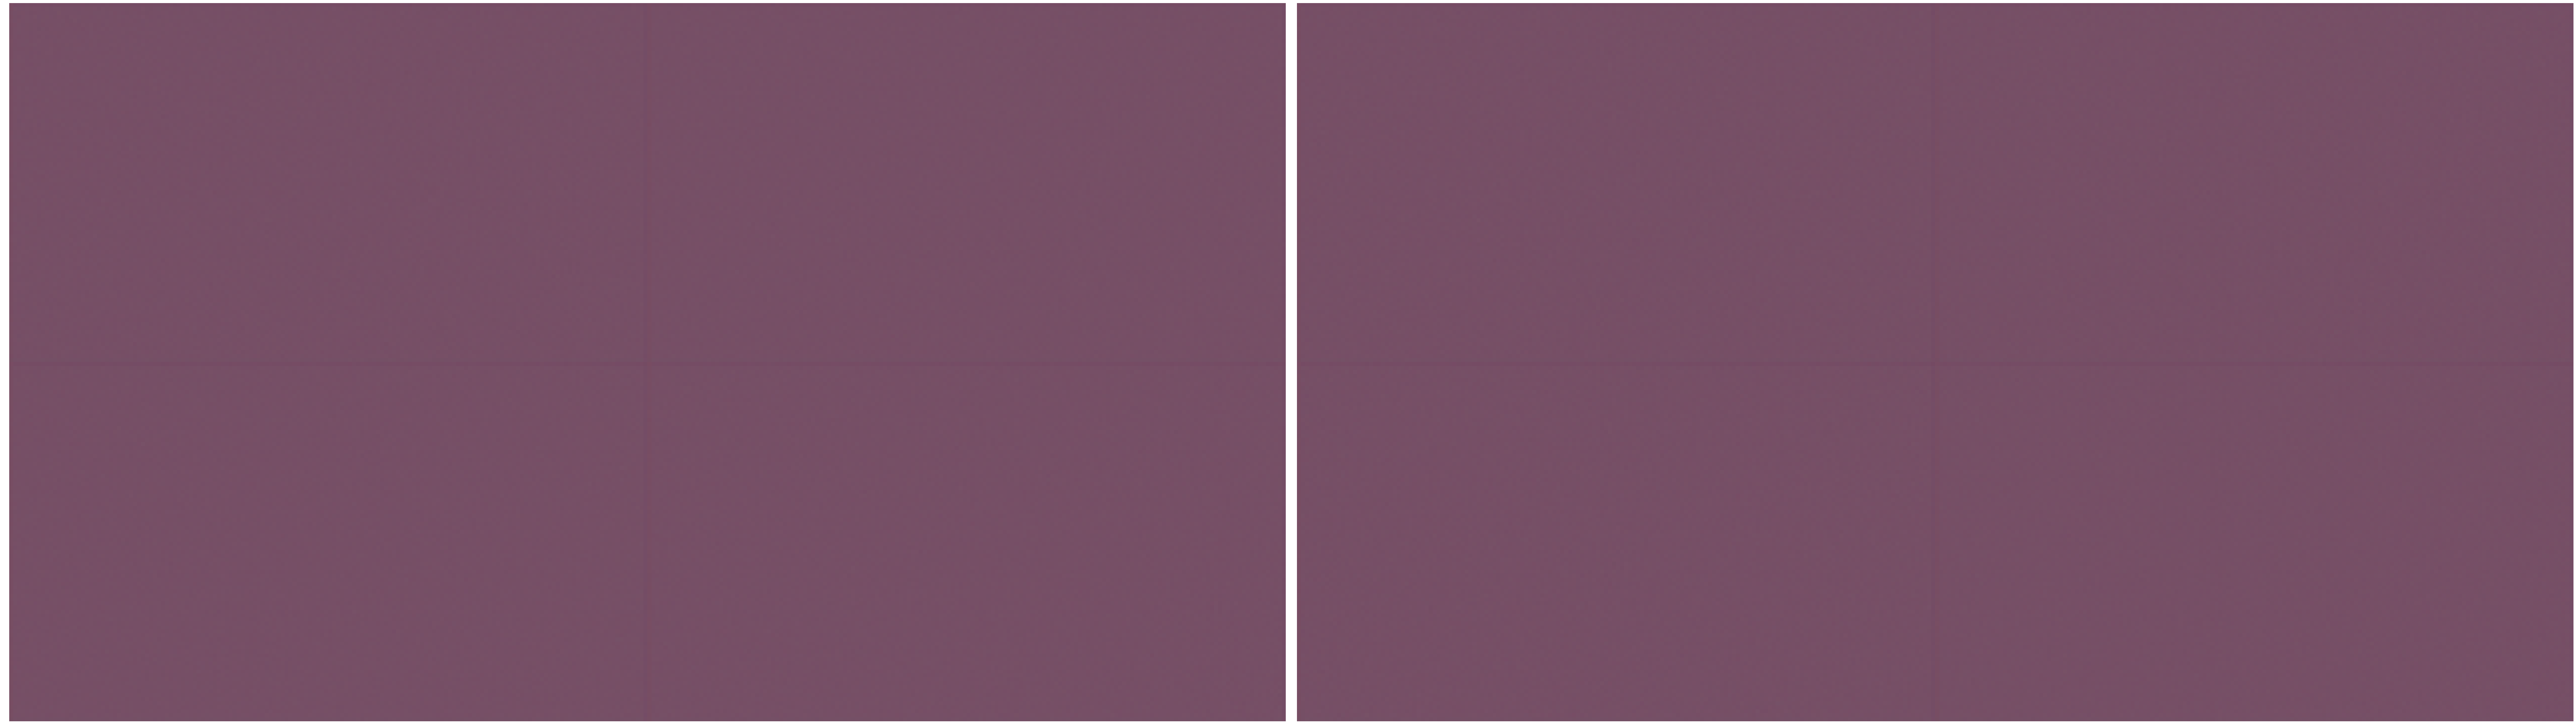

In [7]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,5) ):
    noise = np.random.uniform(0,1,size=[n_ex,input_size])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
#     print(generated_images.shape)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
# no idea if this function works correctly or
def plot_gen_big(n_ex=2, factor=2, dim=(2,2), figsize=(128, 128)):
    noise = np.random.uniform(0,1,size=(n_ex,factor*2*input_size))
    noise = [np.split(n, factor*2) for n in noise]
    noise = np.reshape(np.array(noise), (-1, 100))
    generated_output = generator.predict(np.array(noise))
#     print(generated_output.shape)
    generated_output = np.reshape(np.array(generated_output), (n_ex, factor, factor, *image_size, 3))
#     print(generated_output.shape)
    
    generated_images = np.concatenate(generated_output, axis=2)
#     print(generated_images.shape)
    generated_images = np.concatenate(generated_images, axis=2)
#     print(generated_images.shape)
    generated_images = np.reshape(generated_images, (n_ex, factor*image_size[0], factor*image_size[1], 3))
#     print(generated_images.shape)
    
    plt.figure(figsize=figsize)
#     print(generated_images.shape)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
def plot_input_examples(n_ex=16,dim=(4,4), figsize=(10,5)):
    flow_gen = datagen.flow_from_directory("data/good", shuffle=True, target_size=image_size, batch_size=n_ex, class_mode=None)
    batch = next(flow_gen)
    
    plt.figure(figsize=figsize)
    for i in range(batch.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = batch[i,:,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Example input images")
plot_input_examples(6,(5,6),image_size)
print("Generated outputs")
plot_gen(30,(5,6),image_size)
plot_gen_big(2)


In [8]:
import h5py, pickle

res_str = "{}x{}".format(*image_size)
GAN.save("GAN_{}.h5".format(res_str))
GAN.save_weights("GAN_weights_{}.h5".format(res_str))

# import json
# json.dump(GAN.to_json(), open("GAN.json", "w"))
# # print(GAN.get_weights())
# np.save("GAN_weights", np.array(GAN.get_weights()))
# np.array(GAN.get_weights()).dump("GAN_weights.pickle")